In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
torch.manual_seed(1)
from tqdm import tqdm

In [2]:
# statics 
SAMPLE_SIZE = 1000
STATE_DIM = 12
ACTION_DIM = 2
W_STAR = 0.5 * (0.5 - torch.rand((STATE_DIM,ACTION_DIM)))
X = 0.5 * (0.5 - torch.rand((SAMPLE_SIZE,STATE_DIM))) 
p = torch.softmax(torch.mm(X.double(), W_STAR.double())+1e-12,dim=1)
b = torch.distributions.Categorical(p).sample()
L = torch.eig(torch.mm(X.t().double(), X.double()), eigenvectors=True)[0].max()  
H = torch.mm(X.t().double(), X.double()).float()

/tmp/ipykernel_6109/672206273.py:9: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  L = torch.eig(torch.mm(X.t().double(), X.double()), eigenvectors=True)[0].max()


In [3]:
#
def sample_batch(samples=1):
    j = torch.randperm(X.size()[0])
    return X[j[:samples],:], b[j[:samples]] 
def eval_model(w,X,b,resamples=10): 
    w_param = torch.tensor(w.numpy(), requires_grad=True)
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    logit = torch.mm(X.double(), w_param.double())
    loss = criterion(logit, b.long().view(-1))
    model_eval = loss
    return model_eval  
def get_loss_grad(w, X, b):
    w_param = torch.tensor(w.numpy(), requires_grad=True)
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    logit = torch.mm(X.double(), w_param.double())
    loss = criterion(logit, b.long().view(-1))
    loss.backward()
    return w_param.grad
def get_loss(w, X, b):
    w_param = torch.tensor(w.numpy(), requires_grad=True)
    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    logit = torch.mm(X.double(), w_param.double())
    loss = criterion(logit, b.long().view(-1)) 
    return loss
def get_wstar_diff(w):
    return (W_STAR-w).pow(2).mean()

In [4]:
def train_policy(algo, total_rounds = 1000, batch_size=1, m=1):
    # initialize w
    w = torch.tensor(np.zeros((STATE_DIM,ACTION_DIM)))
    # evaluate
    performance, w_star_diff = [], [] 
    # log stuff
    performance.append(get_loss(w, *sample_batch(samples=SAMPLE_SIZE) ).detach().numpy())
    w_star_diff.append(get_wstar_diff(w.detach().numpy()).detach().numpy())
    # train model over n rounds 
    for k in tqdm(range(1, total_rounds+1)):
        # grab mini-batch
        X_k, b_k = sample_batch(samples=batch_size)  
        # call training algorithm
        w = algo(X_k, b_k, w, k,m) 
        # log stuff
        performance.append(get_loss(w, *sample_batch(samples=SAMPLE_SIZE) ).detach().numpy())
        w_star_diff.append(get_wstar_diff(w.detach().numpy()).detach().numpy())
    # return info 
    return w, performance, w_star_diff


In [5]:
 def SGD_step(X_k_, b_k_, w_k_, k_, m=None):  
    w_k_ = w_k_ - (4 / L) * (1 / k_) ** 0.5 * get_loss_grad(w_k_, X_k_, b_k_) 
    return w_k_

In [6]:
ogd = [np.array(train_policy(SGD_step)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2521.12it/s]


In [6]:
def get_func_grad(w_k_, w_k_i_, X_k_, b_k_, k_):
    eta = 4 * (1 / k_) ** 0.5  
    return get_loss_grad(w_k_, X_k_, b_k_) + (1 / eta) * torch.mm(H, w_k_ - w_k_i_)
def FSGD_step(X_k_, b_k_, w_k_, k_, m=1):  
    X_k_ = X_k_.float() 
    w_k_ = w_k_.float()
    w_k_init = w_k_
    for i in range(m): 
        w_k_ = w_k_ - (4 / L) * (1 / k_) ** 0.5 * get_func_grad(w_k_, w_k_init, X_k_, b_k_, k_) 
    return w_k_

In [8]:
fogd = [np.array(train_policy(FSGD_step)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2354.08it/s]


100%|███████████████████████████████████████| 1000/1000 [03:03<00:00,  5.46it/s]


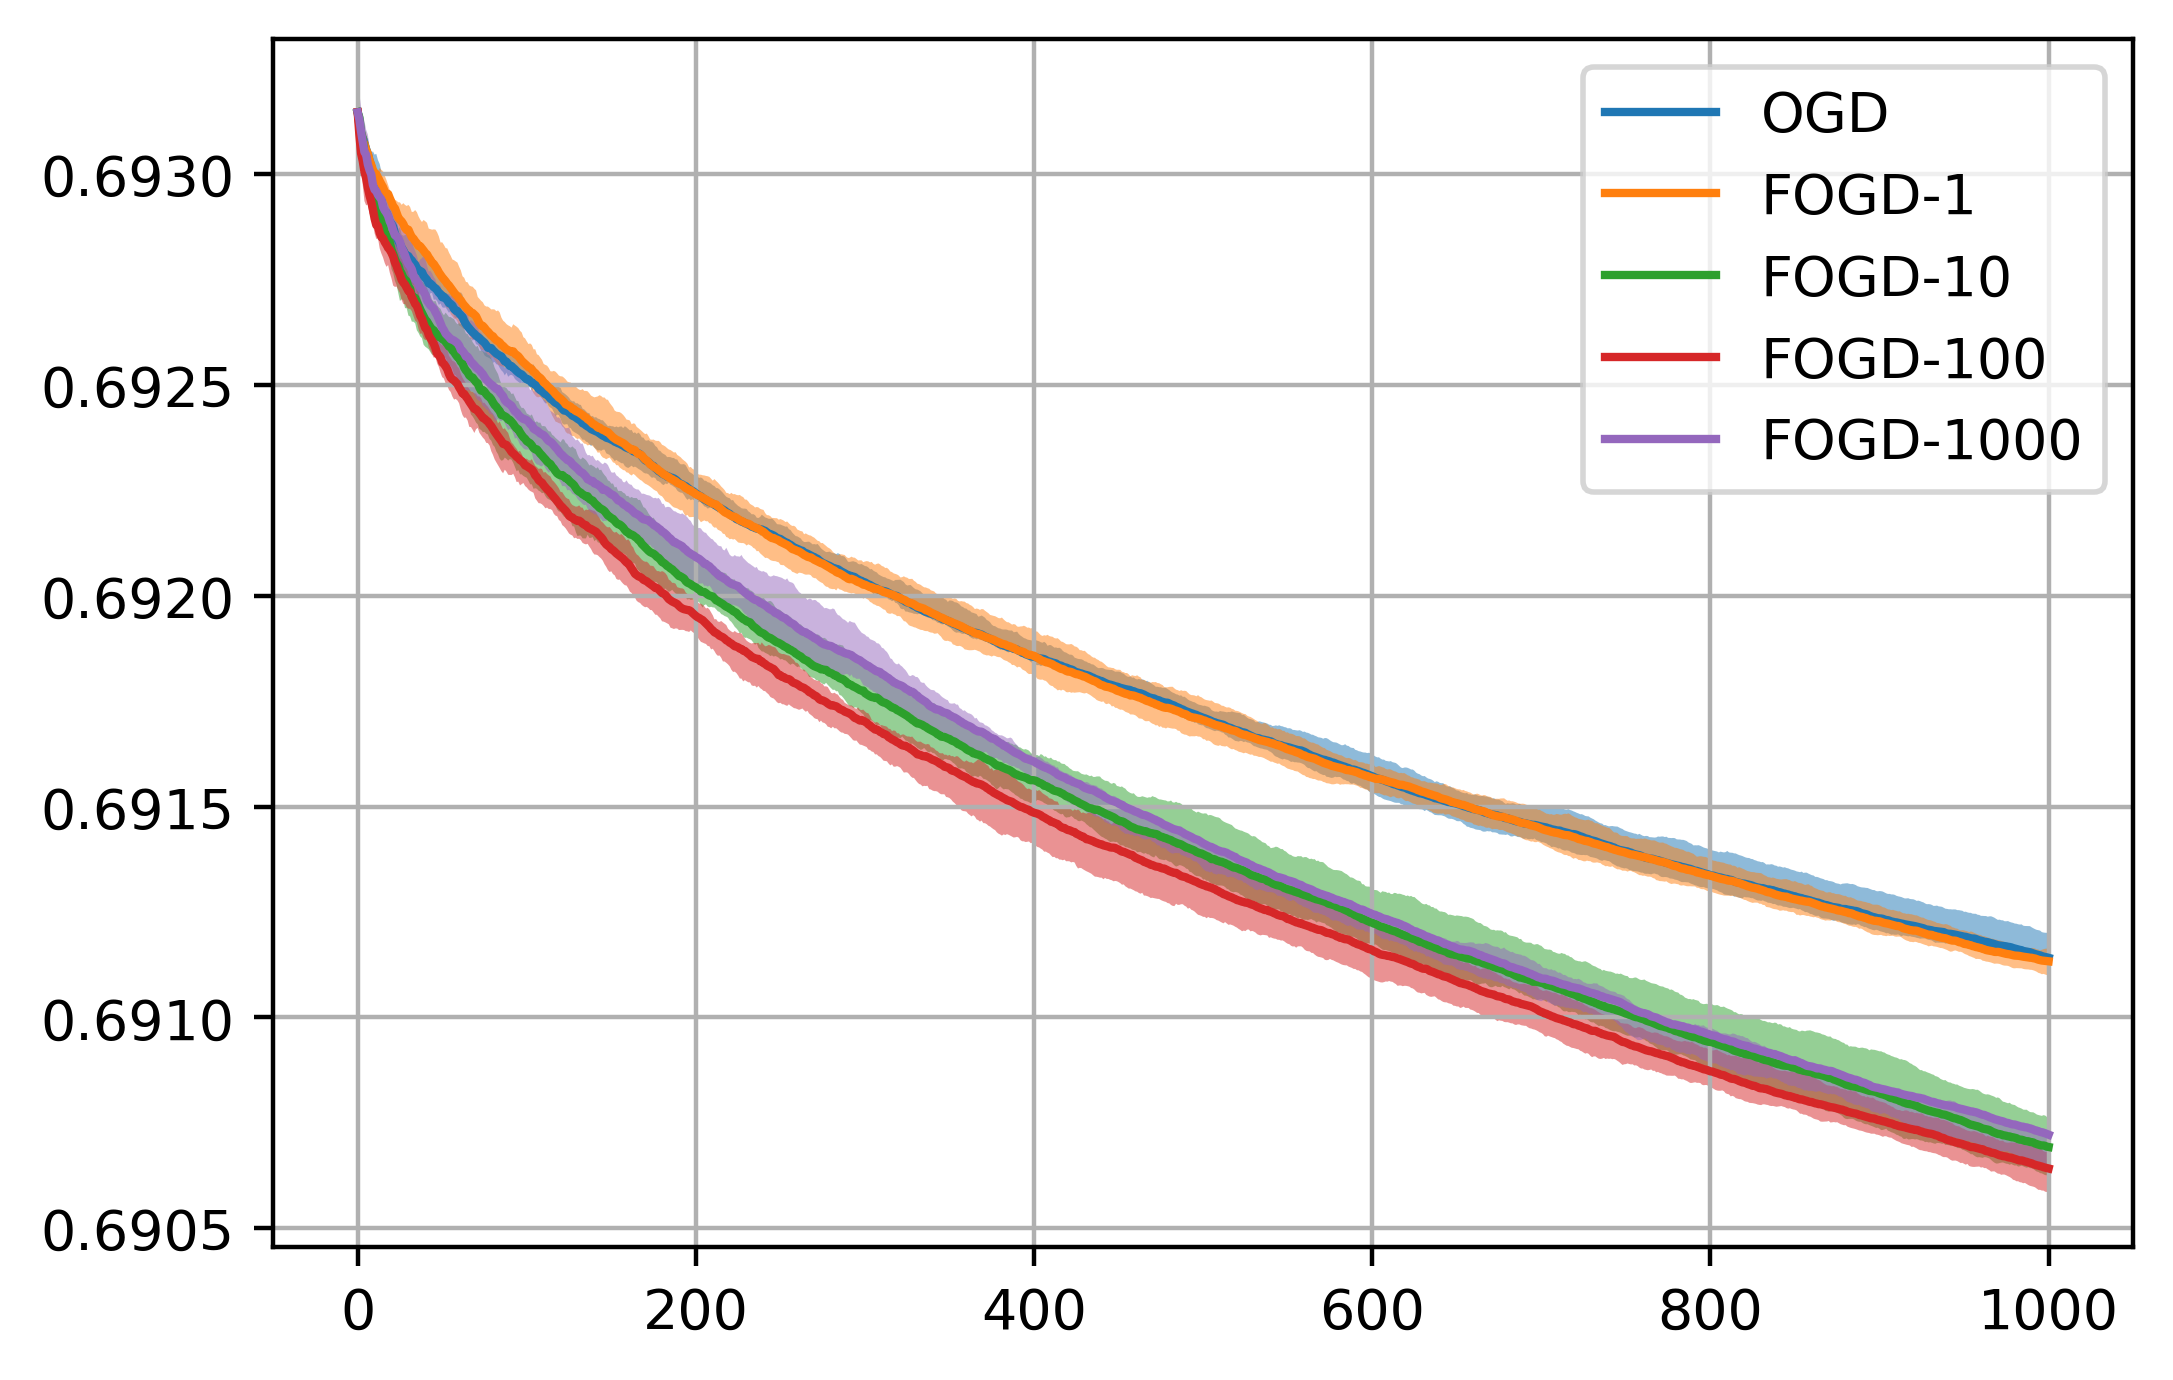

<Figure size 2400x1600 with 0 Axes>

In [13]:
# =================================================
# batch_size=25, alpha=L, same number of samples different # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,batch_size=25,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(FSGD_step,batch_size=25,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 10
fogd = [np.array(train_policy(FSGD_step,batch_size=25,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-10')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 100
fogd = [np.array(train_policy(FSGD_step,batch_size=25,m=100)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-100')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 1000
fogd = [np.array(train_policy(FSGD_step,batch_size=25,m=1000)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1000')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('batch_size=25,alpha=L.png')


100%|███████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]


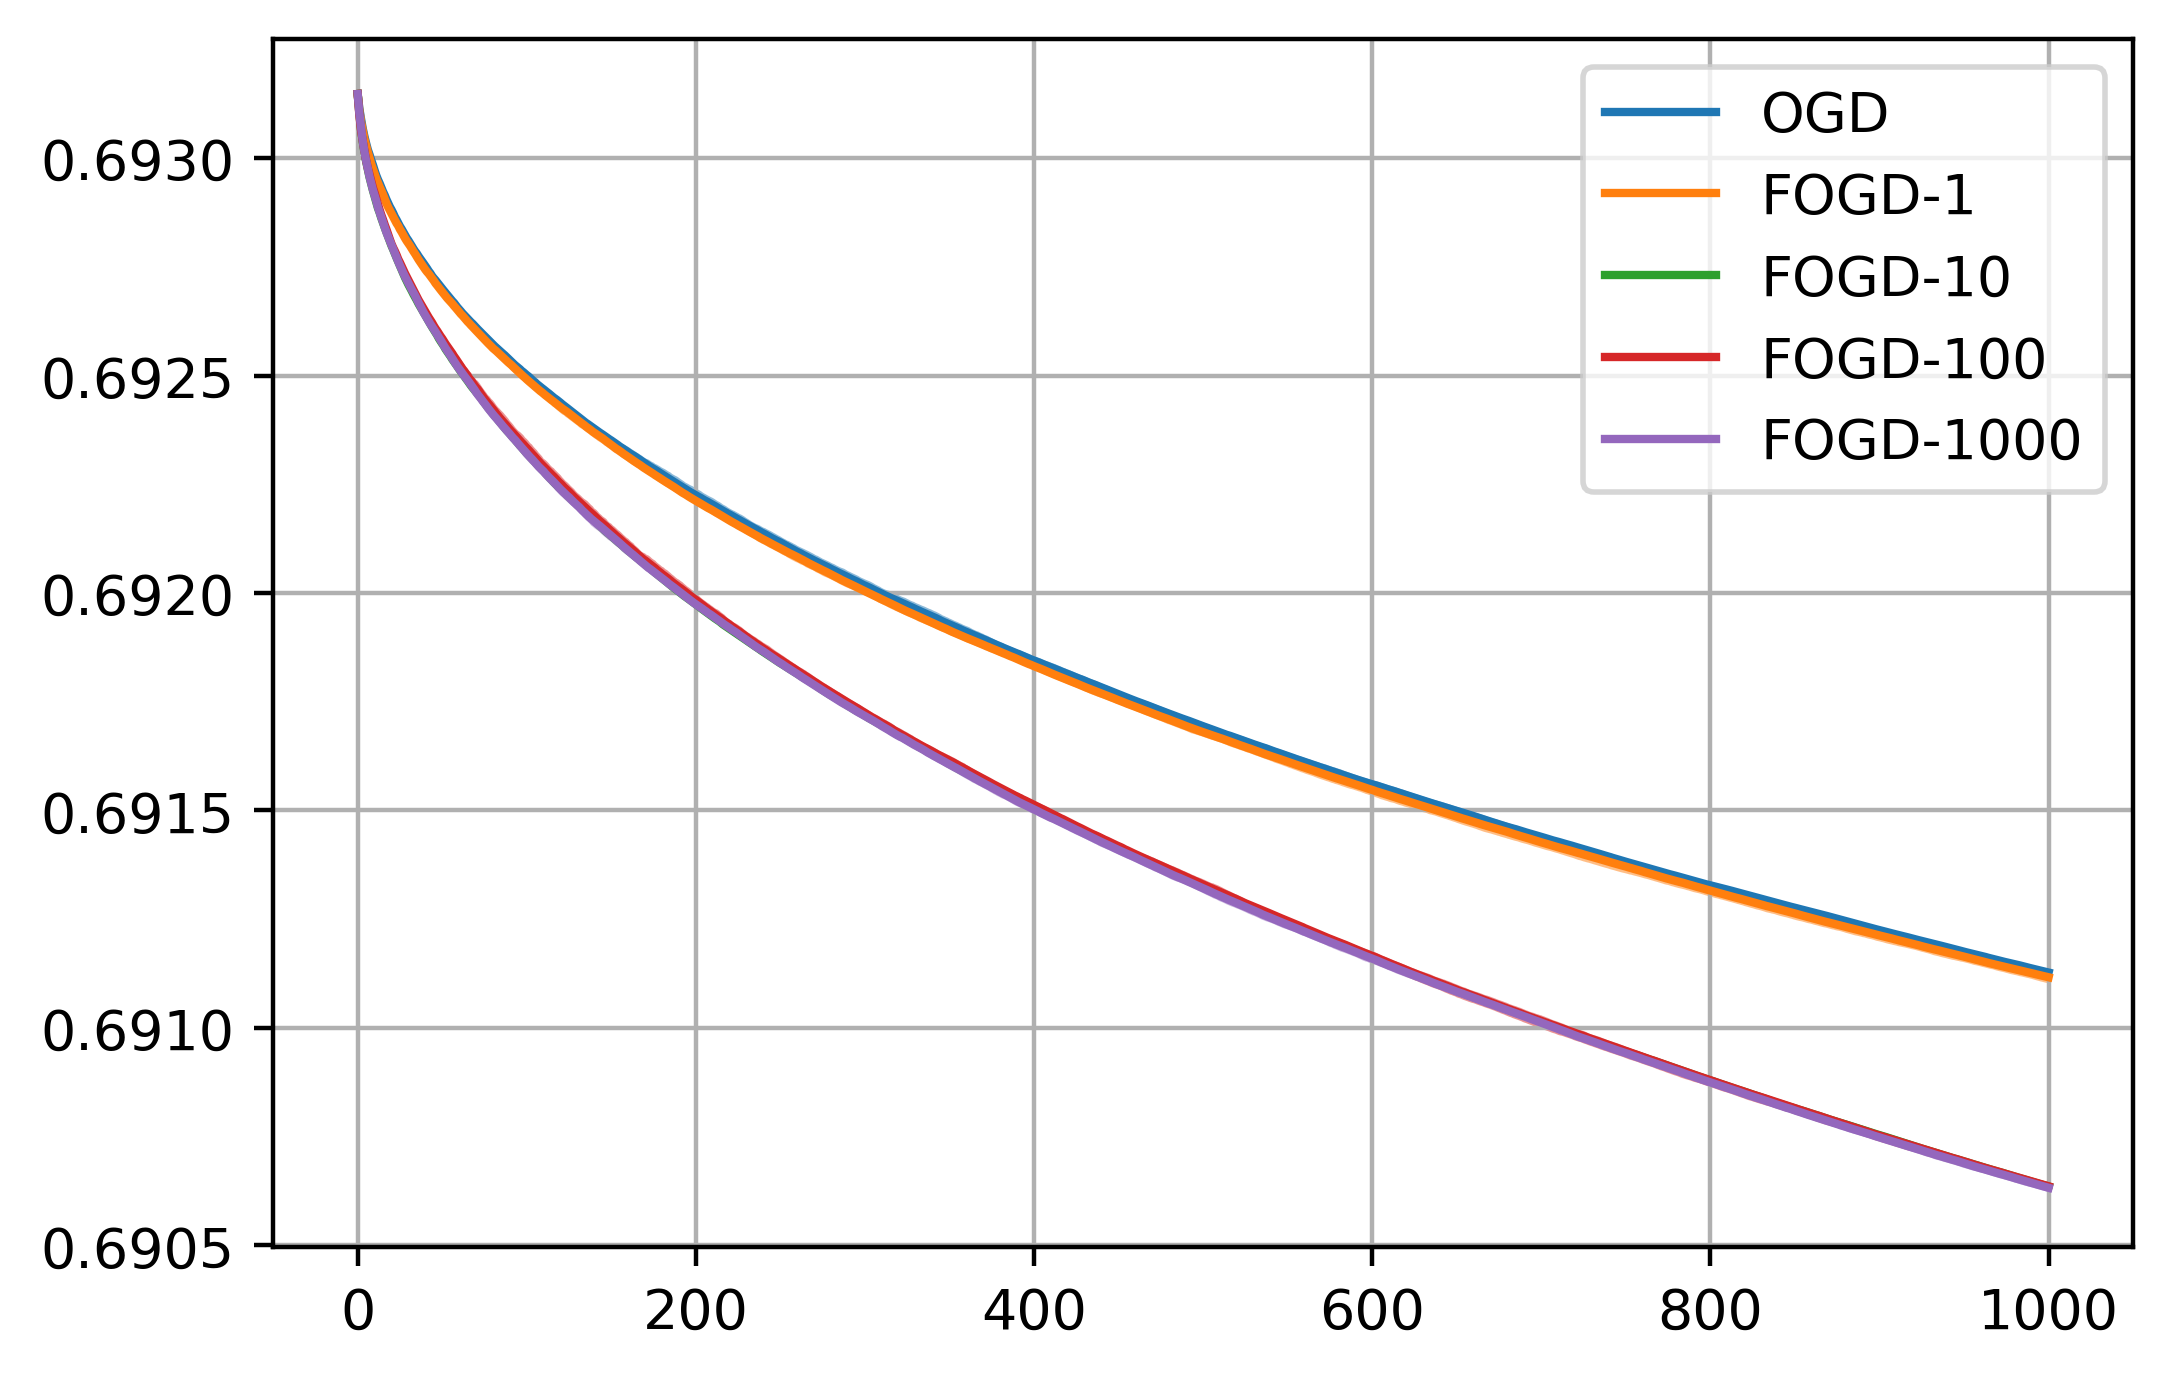

<Figure size 2400x1600 with 0 Axes>

In [14]:
# =================================================
# batch_size=500, alpha=L, same number of samples different # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,batch_size=500,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(FSGD_step,batch_size=500,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 10
fogd = [np.array(train_policy(FSGD_step,batch_size=500,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-10')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 100
fogd = [np.array(train_policy(FSGD_step,batch_size=500,m=100)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-100')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 1000
fogd = [np.array(train_policy(FSGD_step,batch_size=500,m=1000)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1000')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('batch_size=500,alpha=L.png')

100%|███████████████████████████████████████| 1000/1000 [02:51<00:00,  5.85it/s]


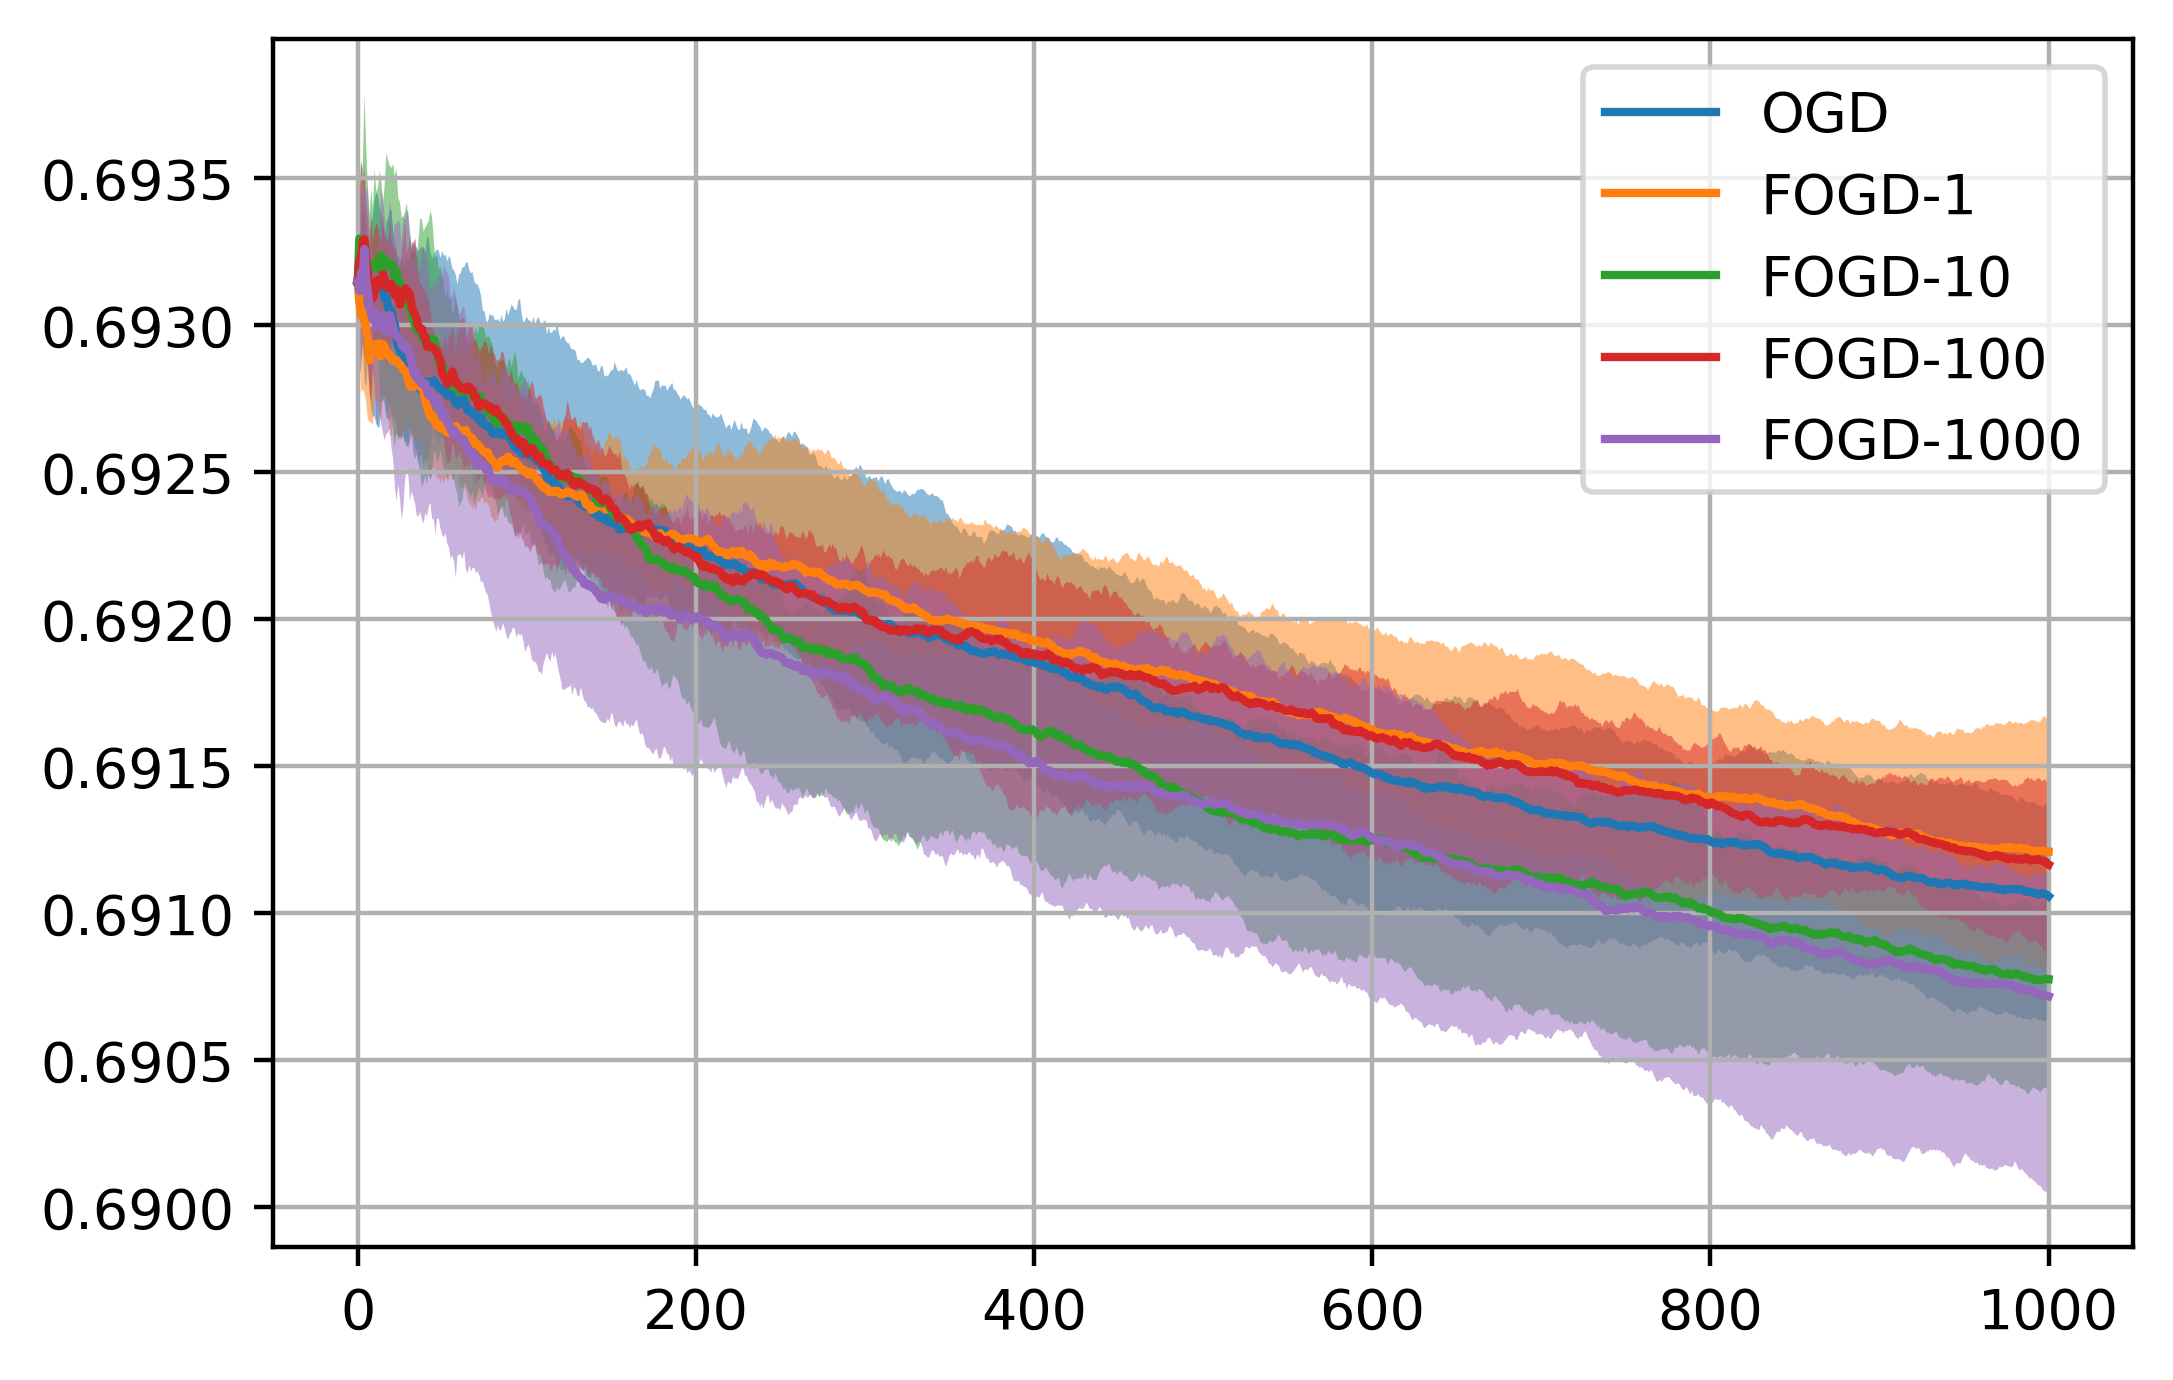

<Figure size 2400x1600 with 0 Axes>

In [15]:
# =================================================
# batch_size=1, alpha=L, same number of samples different # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,batch_size=1,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(FSGD_step,batch_size=1,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 10
fogd = [np.array(train_policy(FSGD_step,batch_size=1,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-10')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 100
fogd = [np.array(train_policy(FSGD_step,batch_size=1,m=100)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-100')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 1000
fogd = [np.array(train_policy(FSGD_step,batch_size=1,m=1000)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1000')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('batch_size=1,alpha=L.png')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


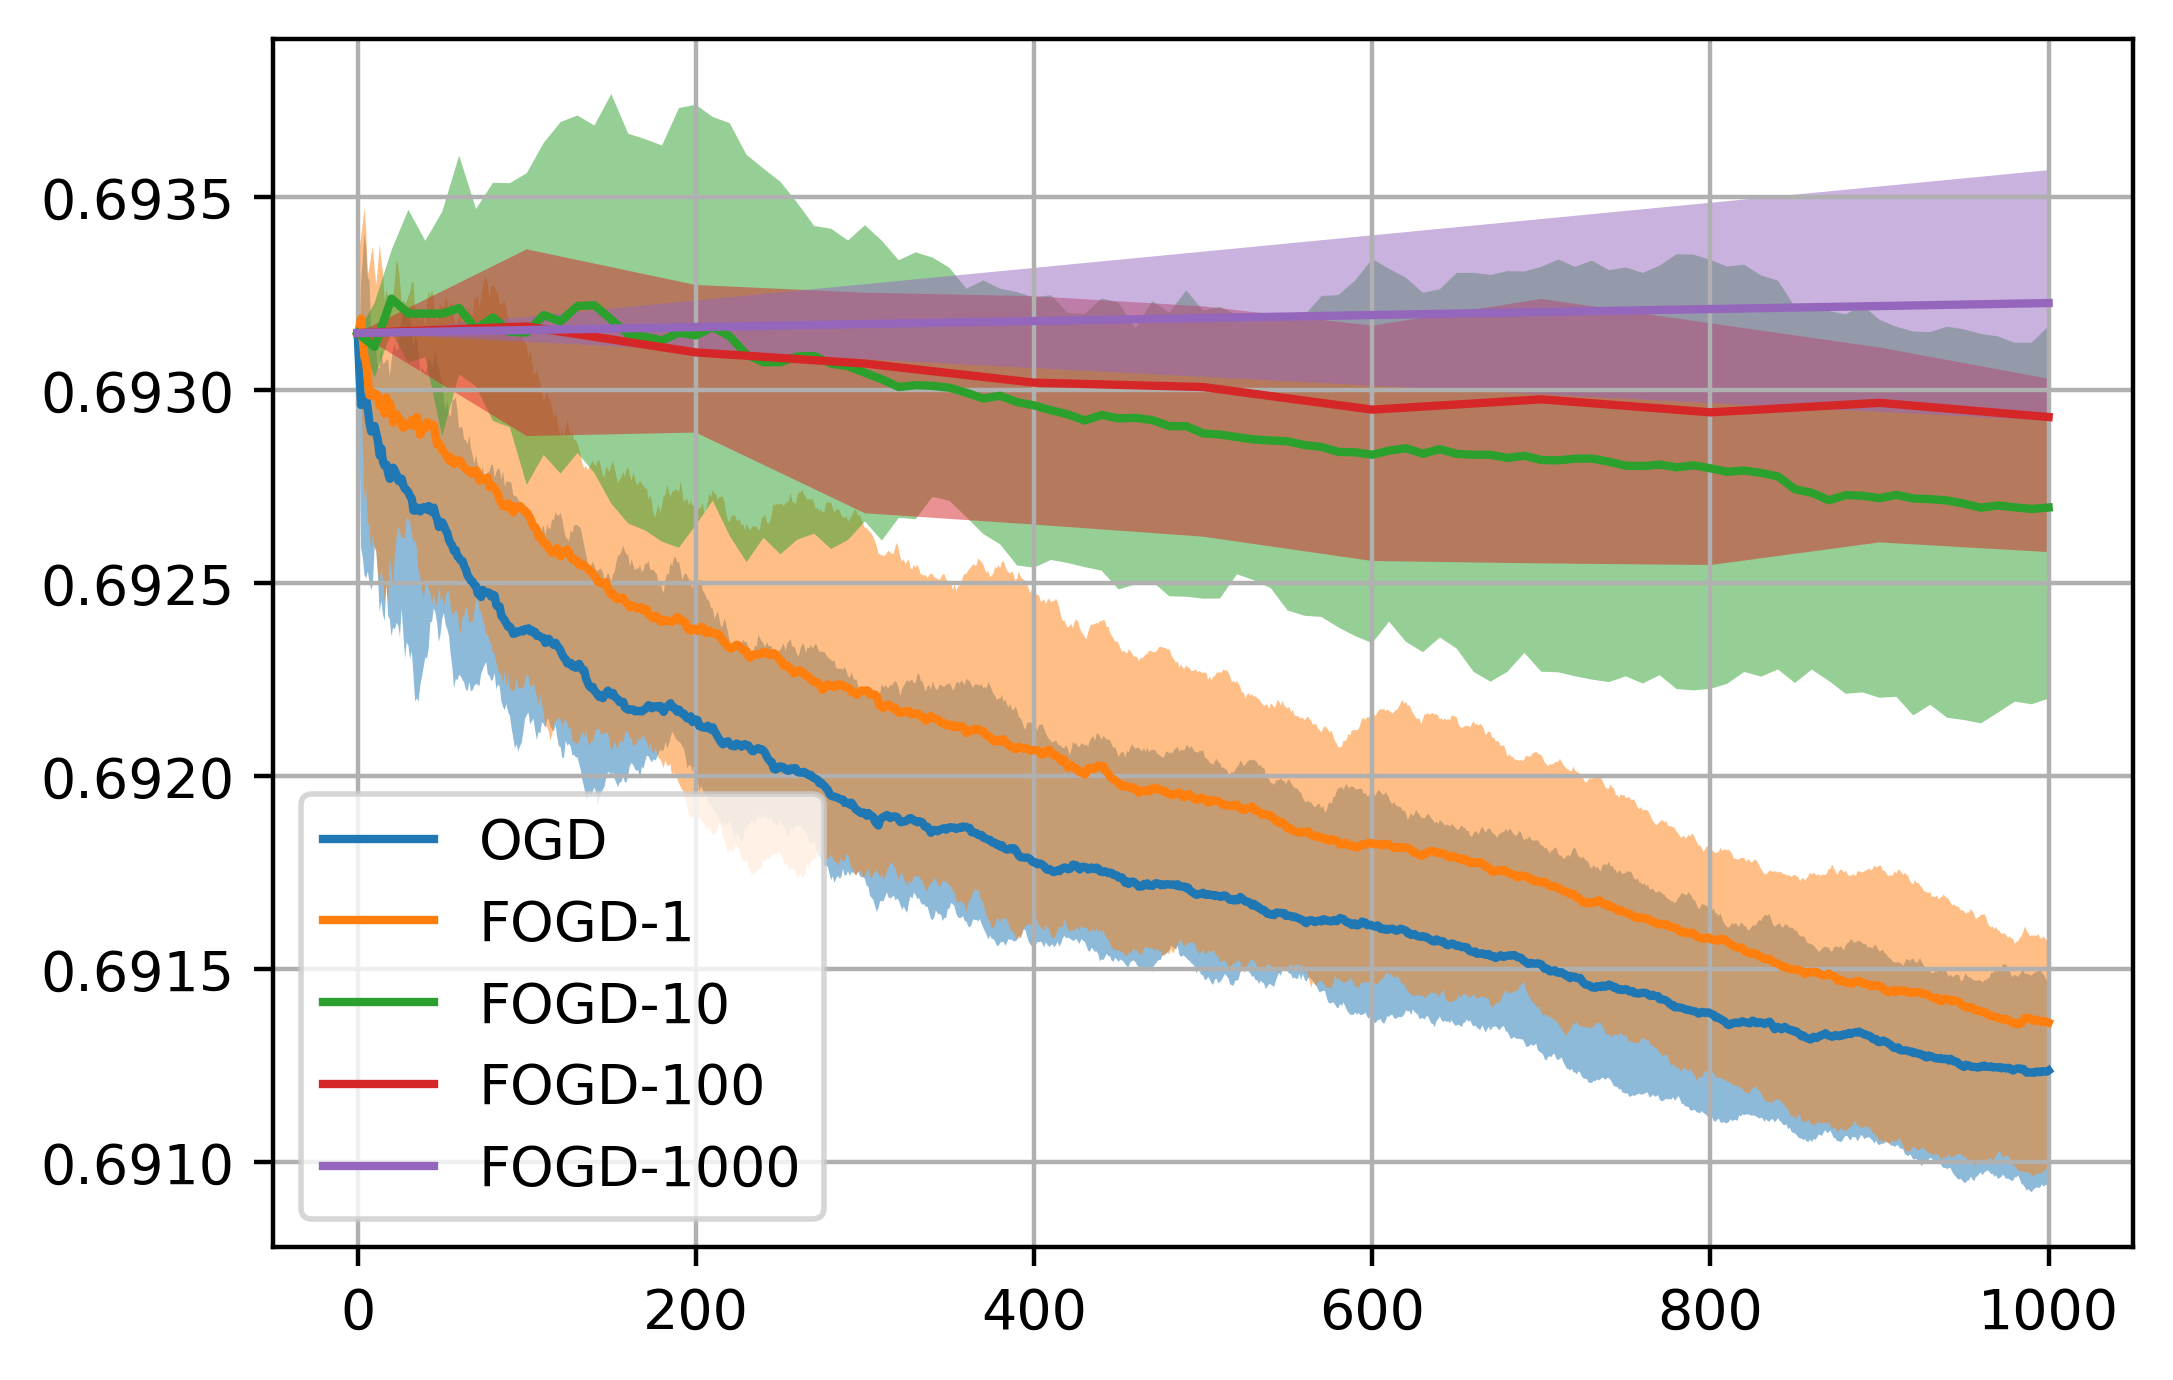

<Figure size 2400x1600 with 0 Axes>

In [26]:
# =================================================
# batch_size=1, alpha=L, same # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,total_rounds = 1000,batch_size=1,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(FSGD_step,total_rounds = 1000,batch_size=1,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 10
fogd = [np.array(train_policy(FSGD_step,total_rounds = 100,batch_size=1,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*10,10), fogd_mean, label='FOGD-10')
ax.fill_between(range(0,len(fogd_mean)*10,10), fogd_max, fogd_min, alpha = 0.5) 
# m = 100
fogd = [np.array(train_policy(FSGD_step,total_rounds = 10,batch_size=1,m=100)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*100,100), fogd_mean, label='FOGD-100')
ax.fill_between(range(0,len(fogd_mean)*100,100), fogd_max, fogd_min, alpha = 0.5) 
# m = 1000
fogd = [np.array(train_policy(FSGD_step,total_rounds = 1,batch_size=1,m=1000)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*1000,1000), fogd_mean, label='FOGD-1000')
ax.fill_between(range(0,len(fogd_mean)*1000,1000), fogd_max, fogd_min, alpha = 0.5) 
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('normed-grad-updates-batch_size=1,alpha=L.png')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


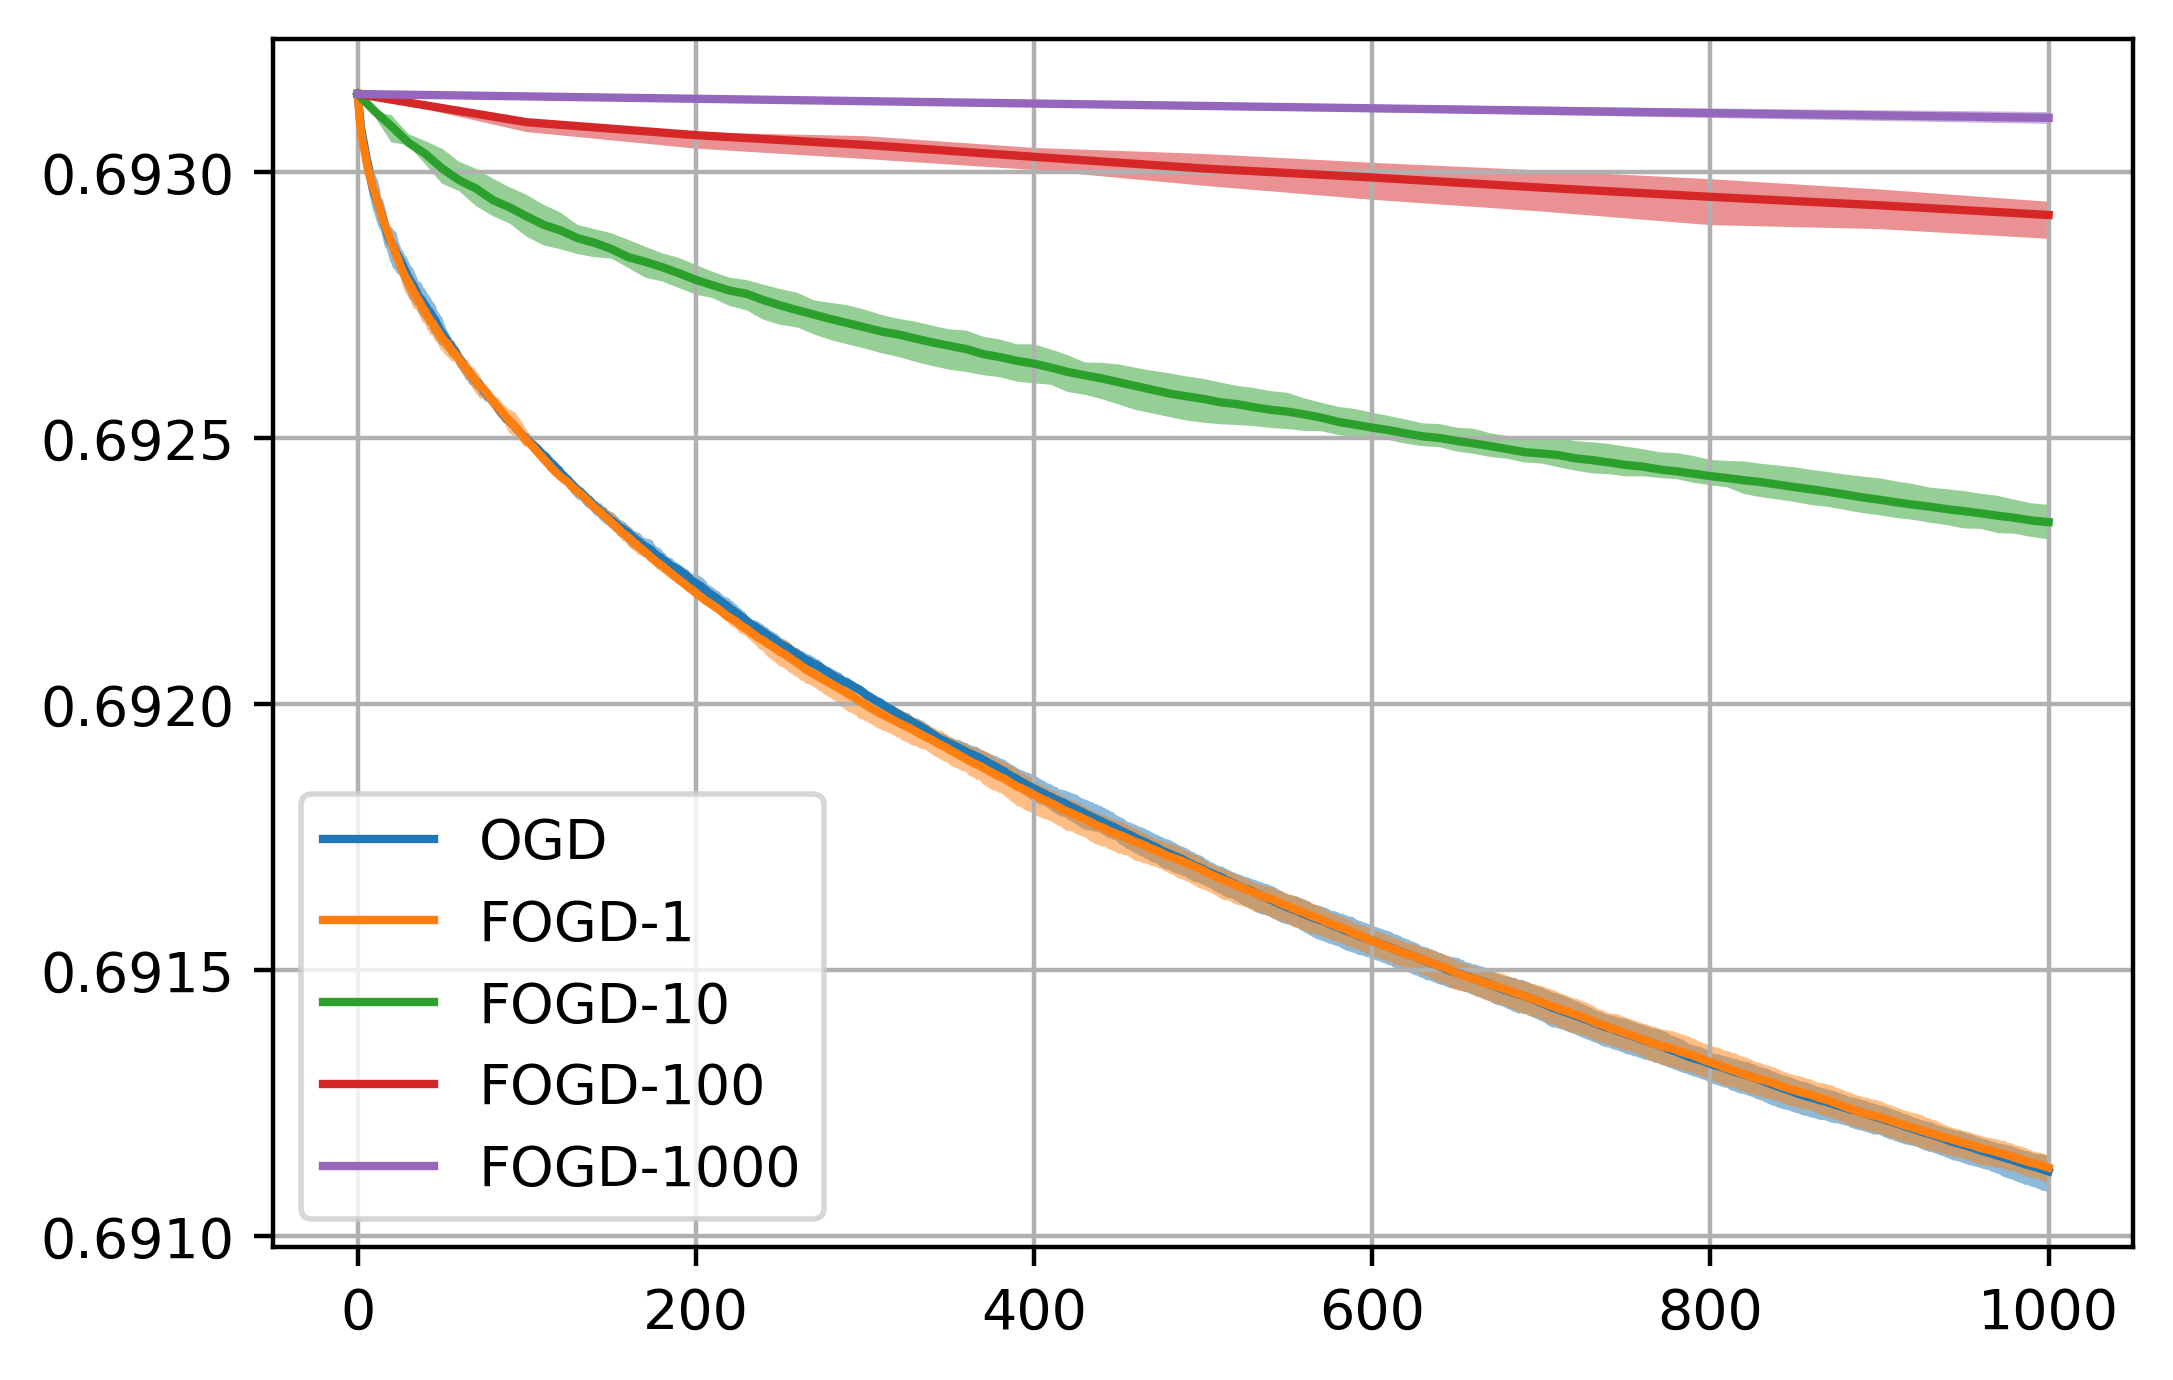

<Figure size 2400x1600 with 0 Axes>

In [29]:
# =================================================
# batch_size=100, alpha=L, same # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,total_rounds = 1000,batch_size=100,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(FSGD_step,total_rounds = 1000,batch_size=100,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 10
fogd = [np.array(train_policy(FSGD_step,total_rounds = 100,batch_size=100,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*10,10), fogd_mean, label='FOGD-10')
ax.fill_between(range(0,len(fogd_mean)*10,10), fogd_max, fogd_min, alpha = 0.5) 
# m = 100
fogd = [np.array(train_policy(FSGD_step,total_rounds = 10,batch_size=100,m=100)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*100,100), fogd_mean, label='FOGD-100')
ax.fill_between(range(0,len(fogd_mean)*100,100), fogd_max, fogd_min, alpha = 0.5) 
# m = 1000
fogd = [np.array(train_policy(FSGD_step,total_rounds = 1,batch_size=100,m=1000)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*1000,1000), fogd_mean, label='FOGD-1000')
ax.fill_between(range(0,len(fogd_mean)*1000,1000), fogd_max, fogd_min, alpha = 0.5) 
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('normed-grad-updates-batch_size=100,alpha=L.png')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.68it/s]


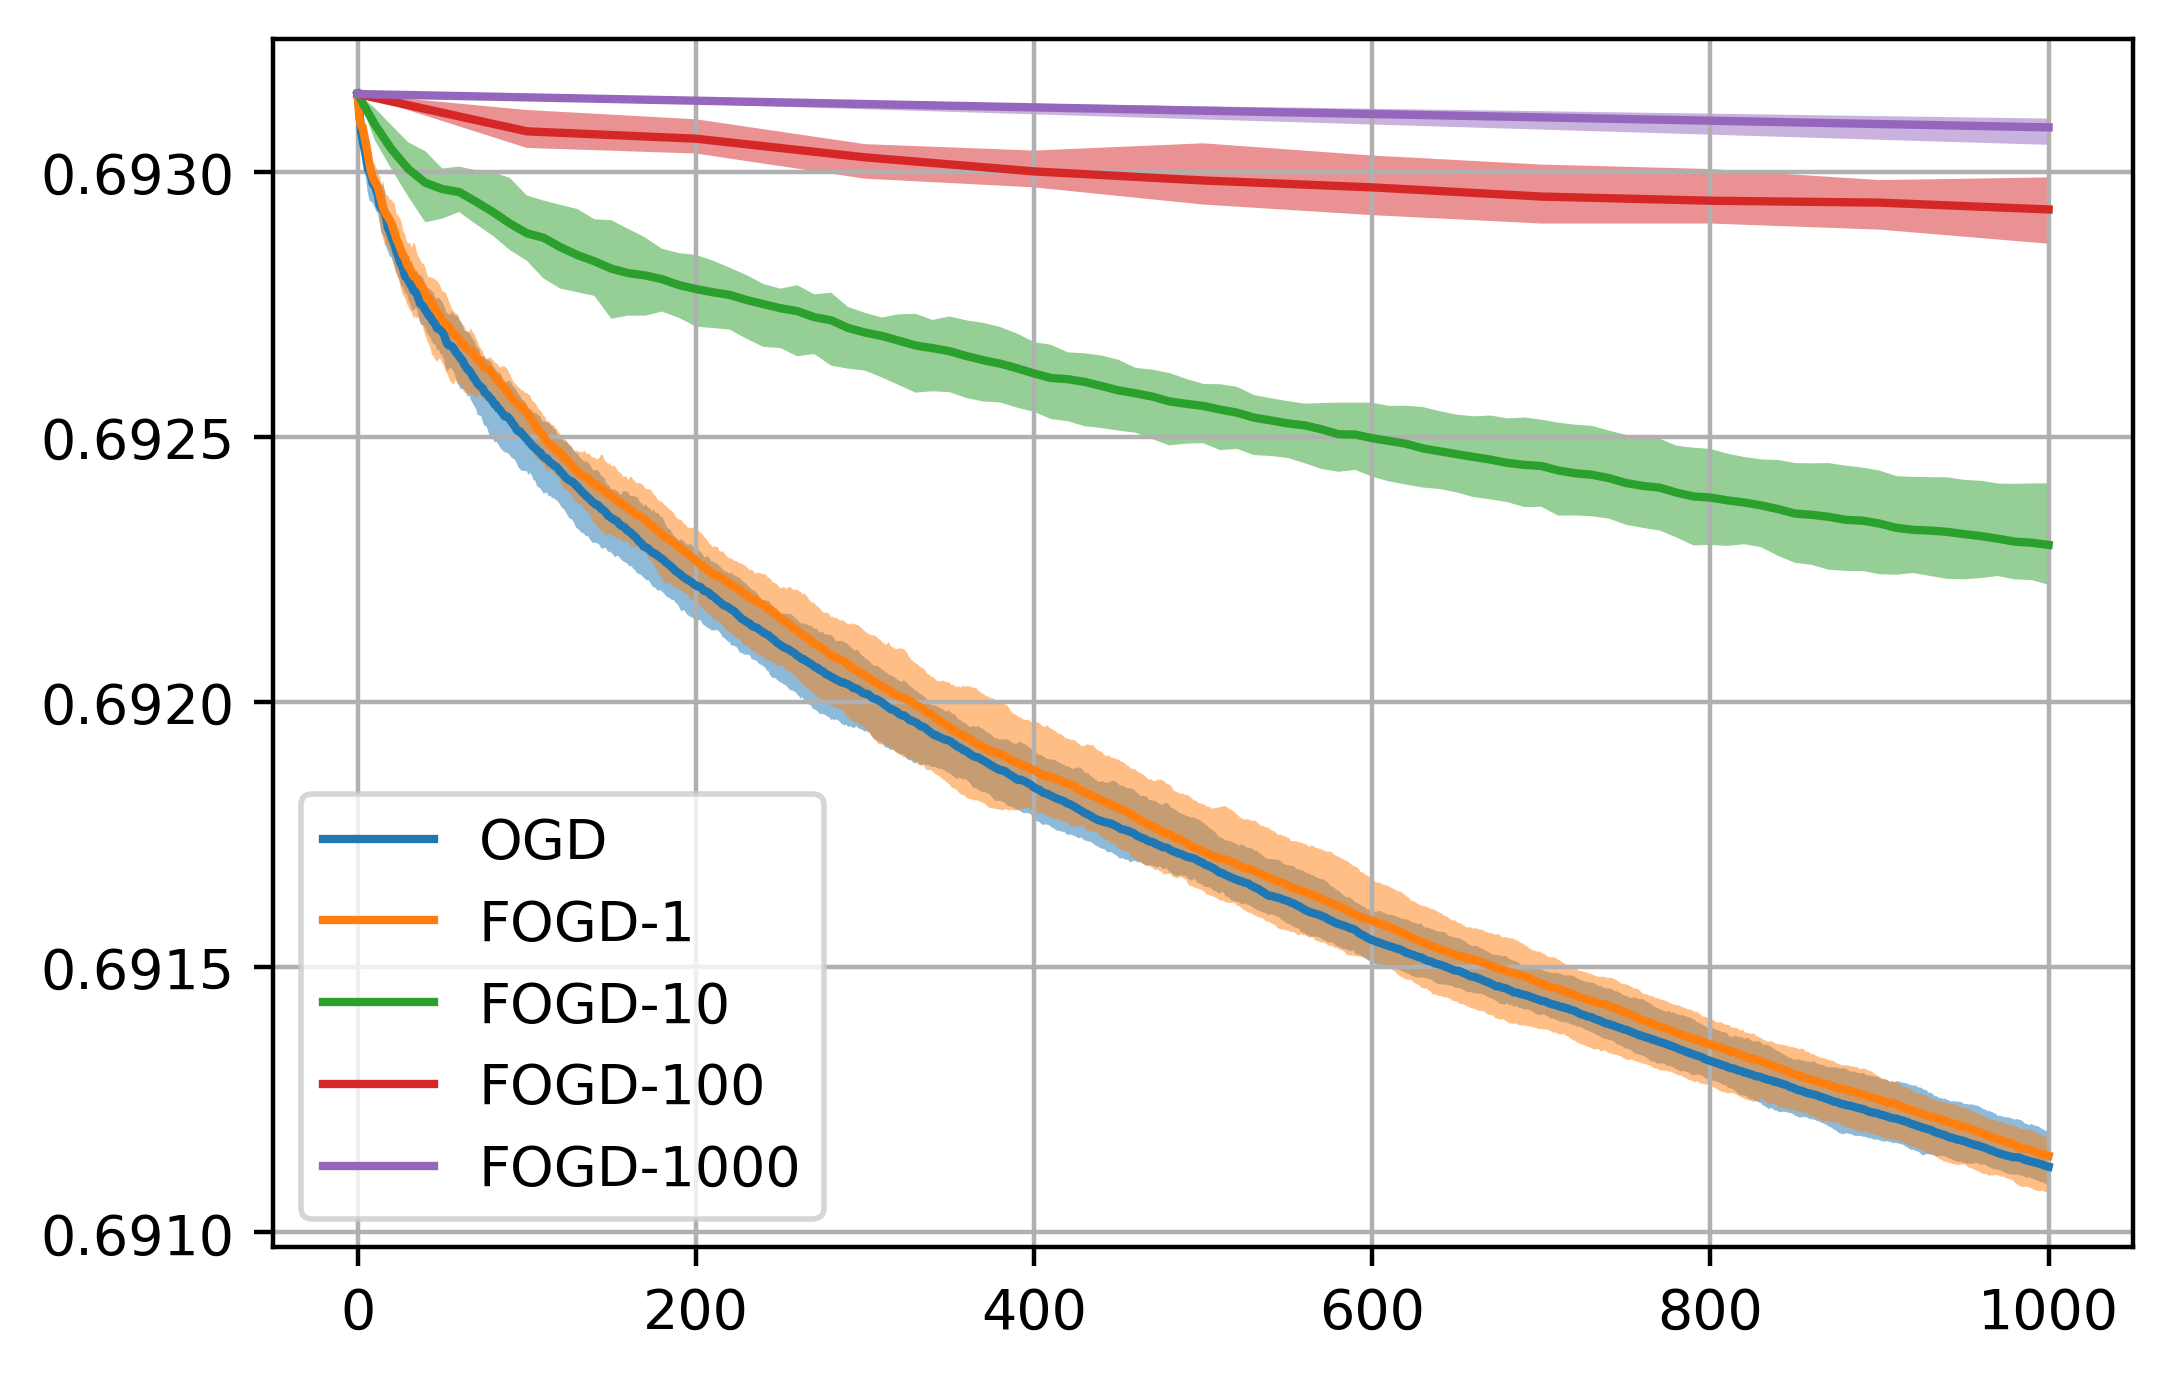

<Figure size 2400x1600 with 0 Axes>

In [30]:
# =================================================
# batch_size=25, alpha=L, same # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,total_rounds = 1000,batch_size=25,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(FSGD_step,total_rounds = 1000,batch_size=25,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 10
fogd = [np.array(train_policy(FSGD_step,total_rounds = 100,batch_size=25,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*10,10), fogd_mean, label='FOGD-10')
ax.fill_between(range(0,len(fogd_mean)*10,10), fogd_max, fogd_min, alpha = 0.5) 
# m = 100
fogd = [np.array(train_policy(FSGD_step,total_rounds = 10,batch_size=25,m=100)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*100,100), fogd_mean, label='FOGD-100')
ax.fill_between(range(0,len(fogd_mean)*100,100), fogd_max, fogd_min, alpha = 0.5) 
# m = 1000
fogd = [np.array(train_policy(FSGD_step,total_rounds = 1,batch_size=25,m=1000)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*1000,1000), fogd_mean, label='FOGD-1000')
ax.fill_between(range(0,len(fogd_mean)*1000,1000), fogd_max, fogd_min, alpha = 0.5)  
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('normed-grad-updates-batch_size=25,alpha=L.png')

In [21]:
# def get_jacobian(X_k_, b_k_, w_k_): 
#     criterion = torch.nn.CrossEntropyLoss(reduction='sum')  
#     w_k_.requires_grad = True  
#     def yeeter(w_k_):
#         return torch.mm(X_k_ , w_k_).t() 
#     dfdw = torch.autograd.functional.jacobian(yeeter, (w_k_))  
#     fuck_you_pytorch = torch.zeros(dfdw.shape[1:])
#     for i in range(b_k_.shape[0]): 
#         fuck_you_pytorch[i,:] = dfdw[b_k_[i],i,:]  
#     return fuck_you_pytorch
# def get_fgrad(X_k_, b_k_, w_k_):  
#     criterion = torch.nn.CrossEntropyLoss(reduction='sum') 
#     f = torch.mm(X_k_ , w_k_.detach())
#     f.requires_grad = True 
#     loss = criterion(f, b_k_)
#     loss.backward()
#     return f.grad # max sure its 1xn
#         grad_Lf = get_fgrad(X_k, b_k, w_k.detach()).t() 
#         jac_w_i = get_jacobian(X_k, b_k, w_k.detach())
#         f_diff = torch.mm(X , w_k.detach()) - torch.mm(X , w_k_init.detach()) 
#         eta = 4 * (1 / k) ** 0.5   
#         fuck_you_grad_Lf=torch.zeros(grad_Lf.shape[1:])
#         fuck_you_f_diff=torch.zeros(f_diff.t().shape[1:])
#         for i in range(b_k.shape[0]): 
#             fuck_you_grad_Lf[i] = grad_Lf[b_k[i],i]  
#             fuck_you_f_diff[i] = f_diff.t()[b_k[i],i]  
#         g_k = torch.matmul( jac_w_i.reshape(*jac_w_i.shape[1:],jac_w_i.shape[0]), fuck_you_grad_Lf) \
#             + (1 / eta) * torch.matmul(jac_w_i.reshape(*jac_w_i.shape[1:],jac_w_i.shape[0]),fuck_you_f_diff) 
#         w_k = w_k - (4 / L) * (1 / k) ** 0.5 * g_k

In [7]:
# imports
import torch
import numpy as np
from copy import deepcopy
import time
# line-search conditions
def check_armijo_conditions(step_size, loss, grad_norm,
                  loss_next, c, beta_b):
    found = 0
    # computing the new break condition
    break_condition = loss_next - \
        (loss - (step_size) * c * grad_norm**2)
    if (break_condition <= 0):
        found = 1
    else:
        # decrease the step-size by a multiplicative factor
        step_size = step_size * beta_b
    return found, step_size
# linesearch optimizer
def get_armijo_step(w_, loss_, loss_grad_, k_):
    # set initial step-sizes 
    step_size= 10 * (4 / L) * (1 / k_) ** 0.5
    c=0.1
    beta_b=0.9 
    expand_coeff=1.8
    #
    gradient = loss_grad_(w_)
    grad_norm = gradient.pow(2).sum().sqrt()
    loss_current = loss_(w_)
    # take some steps
    for e in range(100):
        # =================================================
        # try a prospective step 
        w_props = w_ - step_size * gradient
        # =================================================
        # figure out new loss
        loss_next = loss_(w_props)
        # =================================================
        # Line search
        found, step_size = check_armijo_conditions(step_size, loss_current, grad_norm,
                          loss_next, c, beta_b)
        # =================================================
        # stopping conditions
        if (step_size < 1e-8) or found: 
            break
    # =================================================
    # return the stepsize
    return step_size


In [8]:
def get_func_loss(w_, w_k_init, X_k_, b_k_, k_):
    # compute first term
    base_loss = get_loss(w_, X_k_, b_k_)
    # compute second term
    criterion = torch.nn.CrossEntropyLoss(reduction='sum') 
    f = torch.mm(X_k_ , w_.detach())
    f_k = torch.mm(X_k_ , w_k_init.detach()) 
    f.requires_grad = True  
    loss = criterion(f, b_k_)
    loss.backward()
    L_f = f.grad
    linearized_term = torch.dot(L_f.t()[b_k_].reshape(-1) ,f.t()[b_k_].reshape(-1) -f_k.t()[b_k_].reshape(-1)).reshape(-1)[0]
    # compute third term
    eta = 4 * (1 / k_) ** 0.5 
    reg_term = 1 / ( 2 * eta ) * torch.norm(f.t()[b_k_].reshape(-1) - f_k.t()[b_k_].reshape(-1) , 2).pow(2)
    # compute loss 
#     print(base_loss, linearized_term , reg_term)
    func_loss = base_loss + linearized_term + reg_term
    # return combined surrogate loss
    return func_loss
def LFSGD_step(X_k_, b_k_, w_k_, k_, m=1):  
    X_k_ = X_k_.float() 
    w_k_ = w_k_.float()
    w_k_init = w_k_
    loss_grad_ = lambda w_: get_func_grad(w_, w_k_init, X_k_, b_k_, k_) 
    loss_ = lambda w_: get_func_loss(w_, w_k_init, X_k_, b_k_, k_) 
    for i in range(m): 
        w_k_ = w_k_ - get_armijo_step(w_k_, loss_, loss_grad_, k_) * get_func_grad(w_k_, w_k_init, X_k_, b_k_, k_) 
    return w_k_

In [91]:
lfogd = [np.array(train_policy(LFSGD_step)[1]) for _ in range(10)]  
lfogd_mean, lfogd_max, lfogd_min = np.mean(lfogd, axis=0), np.quantile(lfogd, 0.75, axis=0), np.quantile(lfogd, 0.25, axis=0)

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 805.08it/s]


100%|█████████████████████████████████████████| 500/500 [02:06<00:00,  3.96it/s]


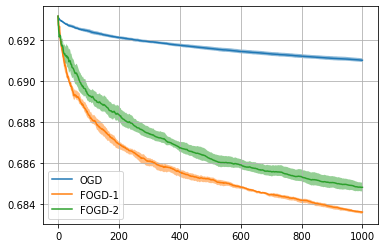

<Figure size 2400x1600 with 0 Axes>

In [10]:
# =================================================
# batch_size=25, alpha=L, same # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,total_rounds = 1000,batch_size=25,m=1)[1]) for _ in range(3)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 1000,batch_size=25,m=1)[1]) for _ in range(3)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 2
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 500,batch_size=25,m=2)[1]) for _ in range(3)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*2,2), fogd_mean, label='FOGD-2')
ax.fill_between(range(0,len(fogd_mean)*2,2), fogd_max, fogd_min, alpha = 0.5)
# # m = 4
# fogd = [np.array(train_policy(LFSGD_step,total_rounds = 250,batch_size=25,m=4)[1]) for _ in range(10)]  
# fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
# ax.plot(range(0,len(fogd_mean)*4,4), fogd_mean, label='FOGD-4')
# ax.fill_between(range(0,len(fogd_mean)*4,4), fogd_max, fogd_min, alpha = 0.5)
# # m = 10
# fogd = [np.array(train_policy(LFSGD_step,total_rounds = 100,batch_size=25,m=10)[1]) for _ in range(10)]  
# fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
# ax.plot(range(0,len(fogd_mean)*10,10), fogd_mean, label='FOGD-10')
# ax.fill_between(range(0,len(fogd_mean)*10,10), fogd_max, fogd_min, alpha = 0.5) 
##
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('normed-grad-updates-batch_size=25,alpha=A.png')

In [ ]:
# =================================================
# batch_size=25, alpha=L, same # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,total_rounds = 1000,batch_size=1,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 1000,batch_size=1,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 2
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 500,batch_size=1,m=2)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*2,2), fogd_mean, label='FOGD-2')
ax.fill_between(range(0,len(fogd_mean)*2,2), fogd_max, fogd_min, alpha = 0.5)
# m = 4
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 250,batch_size=1,m=4)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*4,4), fogd_mean, label='FOGD-4')
ax.fill_between(range(0,len(fogd_mean)*4,4), fogd_max, fogd_min, alpha = 0.5)
# m = 10
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 100,batch_size=1,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*10,10), fogd_mean, label='FOGD-10')
ax.fill_between(range(0,len(fogd_mean)*10,10), fogd_max, fogd_min, alpha = 0.5) 
##
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('normed-grad-updates-batch_size=25,alpha=A.png')

 14%|█████▋                                    | 68/500 [00:02<00:13, 33.17it/s]

In [ ]:
# =================================================
# batch_size=25, alpha=L, same # of gradient evals
fig, ax = plt.subplots()
ogd = [np.array(train_policy(SGD_step,total_rounds = 1000,batch_size=100,m=1)[1]) for _ in range(10)]  
ogd_mean, ogd_max, ogd_min = np.mean(ogd, axis=0), np.quantile(ogd, 0.75, axis=0), np.quantile(ogd, 0.25, axis=0)
ax.plot(ogd_mean, label='OGD')
ax.fill_between(range(len(ogd_mean)), ogd_max, ogd_min, alpha = 0.5)
# m = 1
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 1000,batch_size=100,m=1)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(fogd_mean, label='FOGD-1')
ax.fill_between(range(len(fogd_mean)), fogd_max, fogd_min, alpha = 0.5) 
# m = 2
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 500,batch_size=100,m=2)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*2,2), fogd_mean, label='FOGD-2')
ax.fill_between(range(0,len(fogd_mean)*2,2), fogd_max, fogd_min, alpha = 0.5)
# m = 4
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 250,batch_size=100,m=4)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*4,4), fogd_mean, label='FOGD-4')
ax.fill_between(range(0,len(fogd_mean)*4,4), fogd_max, fogd_min, alpha = 0.5)
# m = 10
fogd = [np.array(train_policy(LFSGD_step,total_rounds = 100,batch_size=100,m=10)[1]) for _ in range(10)]  
fogd_mean, fogd_max, fogd_min = np.mean(fogd, axis=0), np.quantile(fogd, 0.75, axis=0), np.quantile(fogd, 0.25, axis=0)
ax.plot(range(0,len(fogd_mean)*10,10), fogd_mean, label='FOGD-10')
ax.fill_between(range(0,len(fogd_mean)*10,10), fogd_max, fogd_min, alpha = 0.5) 
##
ax.grid()
plt.legend()
plt.rcParams['figure.dpi'] = 400
plt.show()
plt.savefig('normed-grad-updates-batch_size=25,alpha=A.png')

In [2]:
# ===========================================================
# Helpers
import os
import urllib

import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import load_svmlight_file 

LIBSVM_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/"
LIBSVM_DOWNLOAD_FN = {"rcv1"       : "rcv1_train.binary.bz2",
                      "mushrooms"  : "mushrooms",
                      "ijcnn"      : "ijcnn1.tr.bz2",
                      "w8a"        : "w8a", 
                      'cadata'}

def load_libsvm(name, data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)

    fn = LIBSVM_DOWNLOAD_FN[name]
    data_path = os.path.join(data_dir, fn)

    if not os.path.exists(data_path):
        url = urllib.parse.urljoin(LIBSVM_URL, fn)
        print("Downloading from %s" % url)
        urllib.request.urlretrieve(url, data_path)
        print("Download complete.")

    X, y = load_svmlight_file(data_path)
    return X, y

In [6]:
x,y = load_libsvm("mushrooms", "datasets/")


<8124x112 sparse matrix of type '<class 'numpy.float64'>'
	with 170604 stored elements in Compressed Sparse Row format>

ValueError: setting an array element with a sequence.